In [54]:
import numpy as np
import pandas as pd

import pathlib

import pickle

import os
import sys

import math
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

import torch


In [55]:
sys.path.insert(0, "../src")

In [56]:
from custom_distance import KL

# SHAC Results

In [58]:
!ls -l ../output/

total 28
drwxrwxr-x  3 xiruod xiruod_local 4096 Dec  1 22:33 output.small
drwxrwxr-x 10 xiruod xiruod_local 4096 Dec  3 13:26 step101_runExp
drwxrwxr-x 14 xiruod xiruod_local 4096 Feb  3 03:26 step102_runExp_TwoHeads
drwxr-xr-x  4 xiruod domain users 4096 Mar  9 07:08 step102_runExp_TwoHeads_SHAC
drwxrwxr-x  6 xiruod xiruod_local 4096 Jan 11 20:42 step103_runExp_SingleLabel
drwxr-xr-x  3 xiruod domain users 4096 Mar  8 22:46 step103_runExp_SingleLabel_SHAC
drwxr-xr-x  3 xiruod domain users 4096 Mar  8 22:57 step104_runExp_backdoorBERT_SHAC


In [71]:
# path_results = ["../output/step103_runExp_SingleLabel_SHAC/exp_SingleHead_SHAC_05_1/"]
# y_pred_file = "y_pred.csv"
# y_prob_file = "y_prob.csv"

# path_results = ["../output/step102_runExp_TwoHeads_SHAC/exp_TwoHeads_SHAC_05_02/"]
# y_pred_file = "y_main_pred.csv"
# y_prob_file = "y_main_prob.csv"


path_results = ["../output/step102_runExp_TwoHeads_SHAC/exp_GradientReversal_SHAC_05_02/"]
y_pred_file = "y_main_pred.csv"
y_prob_file = "y_main_prob.csv"

In [72]:
df_ls = []

loss = torch.nn.NLLLoss()
for path_i in pathlib.Path(path_results[0]).glob("setting*"):

    with open(pathlib.Path(path_i, "full_settings.pkl"), "br") as f:
        full_setting_i = pickle.load(f)

    for rand_i in path_i.glob("RandomRun_*"):


        num_i = os.path.basename(rand_i).split("_")[1]
        y_pred = pd.read_csv(pathlib.Path(rand_i, y_pred_file))
        y_prob = pd.read_csv(pathlib.Path(rand_i, y_prob_file))
        y_test = pd.read_csv(pathlib.Path(rand_i, "y_test.csv"))

        auprc = metrics.average_precision_score(y_true=y_test, y_score=y_prob.iloc[:,1])
        f1_at_05 = metrics.f1_score(y_true=y_test.values, y_pred=y_prob.iloc[:,1]>0.5)
        _loss = loss(
            torch.log(torch.tensor(y_prob.values)),
            torch.LongTensor(y_test.values).squeeze(1),
        ).item()

        _df = pd.DataFrame.from_dict(full_setting_i['mix_param_dict'], orient='index').T

        _df['distance_KL_Train_Test'] = _df.apply(lambda x: KL([1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']], 
                                                               [1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],),
                                                  axis=1)
        _df['auprc'] = auprc
        _df['f1_at_05'] = f1_at_05
        _df['run'] = num_i
        _df['test_loss'] = _loss

        df_ls.append(_df)

In [73]:
df = pd.concat(df_ls).reset_index(drop=True)

In [74]:
df

,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z,distance_KL_Train_Test,auprc,f1_at_05,run,test_loss
0,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,0.361134,0.454723,0.437500,1,0.649692
1,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,0.361134,0.486860,0.387097,2,0.606616
2,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,0.361134,0.496160,0.379747,3,0.627980
3,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,0.361134,0.432884,0.035714,4,0.630070
4,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,0.361134,0.434038,0.158730,0,0.652251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0.576853,0.648552,0.117647,1,0.650997
996,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0.576853,0.671583,0.297297,2,0.660175
997,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0.576853,0.596892,0.540541,3,0.637562
998,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0.576853,0.628786,0.219178,4,0.660924


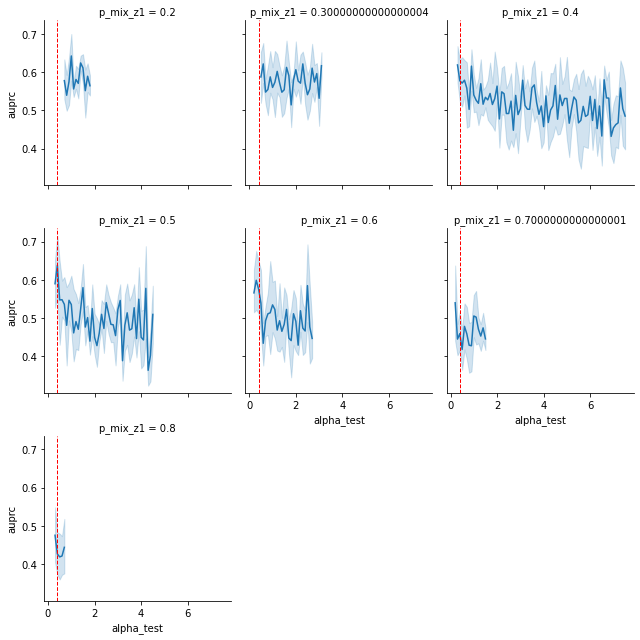

In [75]:
g = sns.FacetGrid(df, col="p_mix_z1", col_wrap=3)

g.map_dataframe(sns.lineplot, x="alpha_test", y="auprc")

g.map(plt.axvline, x=0.4, ls='--', c='red', linewidth=1)

g.set(ylabel="auprc")



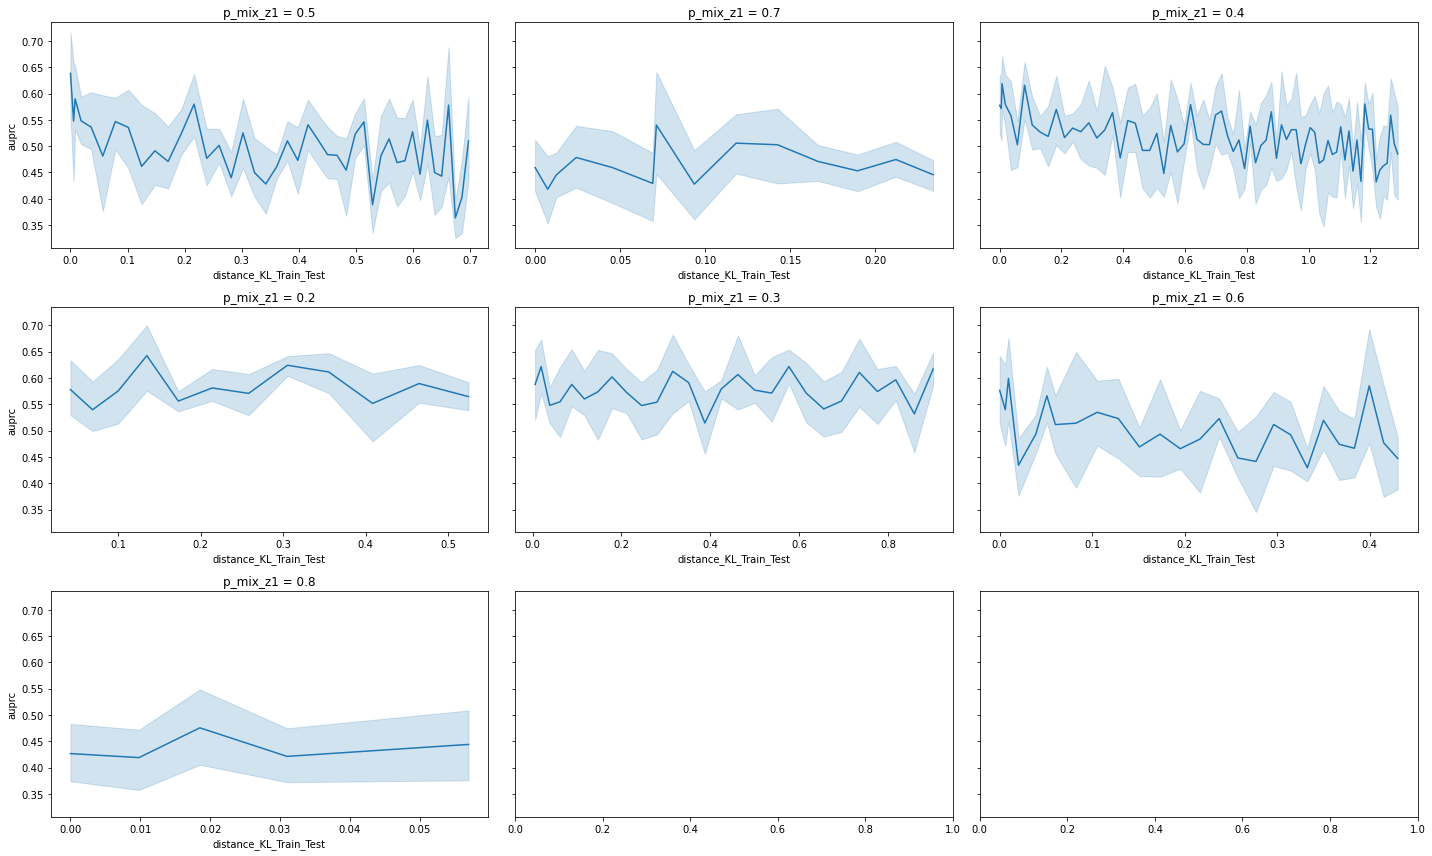

In [76]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,12), sharey=True)
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = "distance_KL_Train_Test"
    _df = df[df['p_mix_z1'] == k].sort_values(xlabel)
    sns.lineplot(data=_df, x=xlabel, y="auprc", ax=ax[idx])

    # ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")

    plt.tight_layout()

# Check Loss

In [49]:
df_ls = []

for path_i in pathlib.Path(path_results[0]).glob("setting*"):
    
    with open(pathlib.Path(path_i, "full_settings.pkl"), "br") as f:
        full_setting_i = pickle.load(f)
        
    for rand_i in path_i.glob("RandomRun_*"):
        
        
        _df = pd.read_csv(pathlib.Path(rand_i, "loss_epoch_avg.csv")).reset_index()
        _df.rename({"index":"epoch_num"}, axis=1, inplace=True)
        _df["epoch_num"] = _df["epoch_num"] + 1
        num_i = os.path.basename(rand_i).split("_")[1]
        
        y_pred = pd.read_csv(pathlib.Path(rand_i, "y_pred.csv"))
        y_prob = pd.read_csv(pathlib.Path(rand_i, "y_prob.csv"))
        y_test = pd.read_csv(pathlib.Path(rand_i, "y_test.csv"))

        _dfSetting = pd.DataFrame.from_dict(full_setting_i['mix_param_dict'], orient = 'index').T        
        _dfSetting['run'] = int(num_i)
        
        for col_i in _dfSetting.columns:
            _df[col_i] = _dfSetting[col_i].values[0]
            
        
        

        
    
        df_ls.append(_df)

In [51]:
df_loss_epoch_avg = pd.concat(df_ls).reset_index(drop=True)

In [53]:
df_loss_epoch_avg

,epoch_num,loss_epoch_avg,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z,run
0,1,0.641346,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,1
1,2,0.619577,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,1
2,3,0.559880,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,1
3,4,0.503103,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,1
4,5,0.460618,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2,0.623703,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0
5996,3,0.573736,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0
5997,4,0.511493,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0
5998,5,0.485128,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0


In [52]:
g = sns.FacetGrid(df_loss_epoch_avg, col="run", row="alpha_test")

g.map_dataframe(sns.lineplot, x="epoch_num", y="loss_epoch_avg")

# g.map(plt.axhline, y=df['test_loss'], ls='--', c='red', linewidth=1)

# g.set(ylabel="auprc")




KeyboardInterrupt



Error in callback <function flush_figures at 0x7fb89ecc1d30> (for post_execute):



KeyboardInterrupt



In [95]:
from sklearn.model_selection import train_test_split
import random

In [102]:
np.random.random()

0.16990016479895875

In [117]:
tmp_train, tmp_test = train_test_split(df, train_size=10,
                                       test_size=5,
                                       shuffle = True, random_state=2023)

In [109]:
tmp_train.index

Int64Index([226, 100, 426, 815, 836, 338, 669, 743, 912, 320], dtype='int64')

In [112]:
tmp_train.index

Int64Index([815, 836, 338, 669, 743, 912, 320, 843, 796, 322], dtype='int64')

In [115]:
tmp_train.index

Int64Index([338, 669, 743, 912, 320, 843, 796, 322, 261, 136], dtype='int64')

In [118]:
tmp_train.index

Int64Index([138, 49, 226, 100, 426, 815, 836, 338, 669, 743], dtype='int64')

In [110]:
tmp_test.index

Int64Index([847, 874, 471, 476, 764, 138, 49], dtype='int64')

In [113]:
tmp_test.index

Int64Index([847, 874, 471, 476, 764, 138, 49, 226, 100, 426], dtype='int64')

In [116]:
tmp_test.index

Int64Index([847, 874, 471, 476, 764, 138, 49, 226, 100, 426, 815, 836], dtype='int64')

In [119]:
tmp_test.index

Int64Index([847, 874, 471, 476, 764], dtype='int64')

In [144]:
tmp_train, tmp_test = train_test_split(df, train_size=15,
                                       test_size=50,
                                       shuffle = True, random_state=100)

In [145]:
tmp_train.index

Int64Index([173, 828, 378, 310, 222, 43, 704, 542, 745, 244, 61, 543, 512, 24,
            547],
           dtype='int64')

In [146]:
tmp_test.index

Int64Index([249, 353, 537, 424, 564, 124, 492, 553, 982, 935, 633, 771, 146,
            672, 727, 395, 330, 923, 315, 629, 956, 216, 930,  44, 116, 639,
            879,  48, 562, 781, 949, 178, 197, 266, 312, 737, 751, 717, 164,
            467, 171, 155, 221, 489, 688, 229, 580, 118, 888, 480],
           dtype='int64')

In [147]:
tmp_train, tmp_test = train_test_split(df, train_size=12,
                                       test_size=40,
                                       shuffle = True, random_state=100)

In [148]:
tmp_train.index

Int64Index([171, 155, 221, 489, 688, 229, 580, 118, 888, 480, 173, 828], dtype='int64')

In [149]:
tmp_test.index

Int64Index([249, 353, 537, 424, 564, 124, 492, 553, 982, 935, 633, 771, 146,
            672, 727, 395, 330, 923, 315, 629, 956, 216, 930,  44, 116, 639,
            879,  48, 562, 781, 949, 178, 197, 266, 312, 737, 751, 717, 164,
            467],
           dtype='int64')